In [9]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os

In [10]:
COMPANY='MSFT'

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
df = pd.read_csv(F'{COMPANY}_data.csv', parse_dates=['Date'],infer_datetime_format=True).set_index('Date')

In [13]:
df.shape

(2933, 54)

In [14]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'lag_1', 'lag_2', 'lag_3',
       'lag_4', 'lag_5', 'lag_10', 'lag_21', 'lag_42', 'lag_63', 'return_1d',
       'return_2d', 'return_3d', 'return_4d', 'return_5d', 'return_10d',
       'return_21d', 'return_42d', 'return_63d', 'rsi', 'bb_high', 'bb_low',
       'atr', 'macd', 'sma_10', 'sma_20', 'sma_50', 'ema_10', 'ema_20',
       'ema_50', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5',
       'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11',
       'month_12', 'target_close', 'target_return_1d', 'target_class'],
      dtype='object')

In [15]:
strategy = 'target_class_all_returns'
target= 'target_class'
features = ['return_1d','return_2d','return_3d','return_4d','return_5d','return_10d',
 'return_21d','return_42d','return_63d']
feature_len = len(features)
print(f'features length: {feature_len}')
cols = features.copy()
cols.append(target)
df = df.filter(cols, axis=1)
df.head()

features length: 9


,return_1d,return_2d,return_3d,return_4d,return_5d,return_10d,return_21d,return_42d,return_63d,target_class
Date,,,,,,,,,,
2012-04-03,-0.010839,-0.009919,-0.005604,-0.007766,-0.017835,-0.001563,0.004403,0.073465,0.200982,0
2012-04-04,-0.022856,-0.033447,-0.032548,-0.028332,-0.030444,-0.021937,-0.011090,0.038871,0.146550,0
2012-04-05,0.009933,-0.013150,-0.023846,-0.022938,-0.018680,-0.015000,-0.010050,0.050579,0.146225,0
2012-04-09,-0.013325,-0.003524,-0.026299,-0.036853,-0.035958,-0.028428,-0.028428,0.031458,0.113652,0
2012-04-10,-0.020257,-0.033312,-0.023710,-0.046024,-0.056364,-0.065050,-0.047515,0.000346,0.105645,0


In [16]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
df_scaled = sc.fit_transform(df)
print(df_scaled)

[[-7.09797175e-01 -5.40046249e-01 -3.28245077e-01 ...  3.91088620e-01
   1.38404534e+00 -2.39411680e-01]
 [-1.42661676e+00 -1.59862330e+00 -1.34349248e+00 ... -3.08109759e-02
   8.38609125e-01 -2.39411680e-01]
 [ 5.29291533e-01 -6.85397083e-01 -1.01560452e+00 ...  1.11981152e-01
   8.35355842e-01 -2.39411680e-01]
 ...
 [-1.29537772e-01  4.32067623e-01 -1.18084000e-01 ...  2.07604526e+00
   1.08319290e+00  4.17690566e+00]
 [ 1.23266701e-01 -3.25845329e-03  4.42449841e-01 ...  2.09144008e+00
   1.09369643e+00  4.17690566e+00]
 [ 5.81178023e-01  5.34477232e-01  3.66566248e-01 ...  2.21071364e+00
   1.05031436e+00 -2.39411680e-01]]


In [17]:
# multiple feature from data provided to the model
X = []
backcandles = 60
print(df_scaled.shape[0])
for j in range(feature_len):
    X.append([])
    for i in range(backcandles, df_scaled.shape[0]):
        X[j].append(df_scaled[i-backcandles:i, j])

2933


In [18]:
#move axis from 0 to position 2
X=np.moveaxis(X, [0], [2])
X

array([[[-0.70979718, -0.54004625, -0.32824508, ..., -0.27063571,
          0.39108862,  1.38404534],
        [-1.42661676, -1.5986233 , -1.34349248, ..., -0.52338868,
         -0.03081098,  0.83860913],
        [ 0.52929153, -0.68539708, -1.01560452, ..., -0.50642877,
          0.11198115,  0.83535584],
        ...,
        [-1.67597491, -0.4968101 , -1.40840402, ...,  0.10649939,
         -1.31313523, -1.40594595],
        [ 0.23633158, -1.0903365 , -0.26710434, ...,  0.19648048,
         -1.22387392, -1.33952564],
        [ 0.23483005,  0.35813207, -0.76758439, ..., -0.00580347,
         -1.11963919, -1.19707424]],

       [[-1.42661676, -1.5986233 , -1.34349248, ..., -0.52338868,
         -0.03081098,  0.83860913],
        [ 0.52929153, -0.68539708, -1.01560452, ..., -0.50642877,
          0.11198115,  0.83535584],
        [-0.8580817 , -0.25231818, -1.10803816, ..., -0.80625358,
         -0.12122313,  0.50895526],
        ...,
        [ 0.23633158, -1.0903365 , -0.26710434, ...,  

In [19]:
# Choose -1 for target column
X, yi =np.array(X), np.array(df_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))
print(X)
print(X.shape)
print(y)
print(y.shape)

[[[-0.70979718 -0.54004625 -0.32824508 ... -0.27063571  0.39108862
    1.38404534]
  [-1.42661676 -1.5986233  -1.34349248 ... -0.52338868 -0.03081098
    0.83860913]
  [ 0.52929153 -0.68539708 -1.01560452 ... -0.50642877  0.11198115
    0.83535584]
  ...
  [-1.67597491 -0.4968101  -1.40840402 ...  0.10649939 -1.31313523
   -1.40594595]
  [ 0.23633158 -1.0903365  -0.26710434 ...  0.19648048 -1.22387392
   -1.33952564]
  [ 0.23483005  0.35813207 -0.76758439 ... -0.00580347 -1.11963919
   -1.19707424]]

 [[-1.42661676 -1.5986233  -1.34349248 ... -0.52338868 -0.03081098
    0.83860913]
  [ 0.52929153 -0.68539708 -1.01560452 ... -0.50642877  0.11198115
    0.83535584]
  [-0.8580817  -0.25231818 -1.10803816 ... -0.80625358 -0.12122313
    0.50895526]
  ...
  [ 0.23633158 -1.0903365  -0.26710434 ...  0.19648048 -1.22387392
   -1.33952564]
  [ 0.23483005  0.35813207 -0.76758439 ... -0.00580347 -1.11963919
   -1.19707424]
  [-0.57730493 -0.25862234 -0.06662915 ... -0.02551938 -1.23378729
   -1.

In [20]:
test_len = 260
train_end_idx = -test_len
test_start_idx = -test_len
X_train, X_test = X[:train_end_idx], X[test_start_idx:]
y_train, y_test = y[:train_end_idx], y[test_start_idx:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

(2613, 60, 9)
(260, 60, 9)
(2613, 1)
(260, 1)
[[-0.23941168]
 [-0.23941168]
 [-0.23941168]
 ...
 [ 4.17690566]
 [-0.23941168]
 [-0.23941168]]


In [21]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#tf.random.set_seed(20)

lstm_input = Input(shape=(backcandles, feature_len), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
157/157 [==============================] - 11s 55ms/step - loss: 0.1422 - val_loss: 3.4914
Epoch 2/30
157/157 [==============================] - 10s 64ms/step - loss: 0.1280 - val_loss: 3.6926
Epoch 3/30
157/157 [==============================] - 11s 67ms/step - loss: 0.1274 - val_loss: 3.4374
Epoch 4/30
157/157 [==============================] - 8s 50ms/step - loss: 0.1260 - val_loss: 3.6475
Epoch 5/30
157/157 [==============================] - 11s 68ms/step - loss: 0.1188 - val_loss: 3.5822
Epoch 6/30
157/157 [==============================] - 8s 53ms/step - loss: 0.1224 - val_loss: 3.4336
Epoch 7/30
157/157 [==============================] - 10s 63ms/step - loss: 0.1130 - val_loss: 3.6141
Epoch 8/30
157/157 [==============================] - 10s 67ms/step - loss: 0.1096 - val_loss: 3.4669
Epoch 9/30
157/157 [==============================] - 8s 49ms/step - loss: 0.1138 - val_loss: 3.5354
Epoch 10/30
157/157 [==============================] - 11s 68ms/step - loss: 0.1055 -

In [22]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

9/9 [==============================] - 1s 24ms/step
[-0.11653854] [-0.23941168]
[-0.19850238] [4.17690566]
[-0.23718737] [-0.23941168]
[-0.24124011] [-0.23941168]
[-0.23289871] [-0.23941168]
[-0.24524951] [4.17690566]
[-0.22592138] [-0.23941168]
[-0.20049639] [-0.23941168]
[-0.20449406] [-0.23941168]
[-0.25057954] [4.17690566]


In [23]:
# inverse pred values
import numpy as np
df_copy_pred = np.zeros(shape=(len(y_test), feature_len+1) )
df_copy_pred[:,feature_len] = y_pred[:,0]
df_copy_pred[-1]
y_inversed_pred = sc.inverse_transform(df_copy_pred)[:,feature_len]

In [24]:
# inverse y test values
df_copy_test = np.zeros(shape=(len(y_test), feature_len+1) )
df_copy_test[:,feature_len] = y_test[:,0]
df_copy_test[-1]
y_inversed_test = sc.inverse_transform(df_copy_test)[:,feature_len]

In [25]:
y_inversed_pred_cat = [1 if y_inversed_pred[i] >= 0.5 else 0 for i in range(len(y_inversed_pred))]
y_inversed_pred_cat

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [26]:
# inverse y test values
df_copy_test = np.zeros(shape=(len(y_test), feature_len+1) )
df_copy_test[:,feature_len] = y_test[:,0]
df_copy_test[-1]
y_inversed_test = sc.inverse_transform(df_copy_test)[:,feature_len]

In [27]:
def plot_predictions(y_test, y_pred):
    #Get the confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    #sns.heatmap(cf_matrix, annot=True)
    #sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,
    #        fmt='.2%', cmap='Blues')
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    print(cf_matrix)
    plt.show()

In [28]:
def classification_results(y_true, y_pred, strategy):
    accuracy = metrics.accuracy_score(y_true, y_pred)
    #accuracy = metrics.accuracy_score(y_true, np.argmax(y_pred, axis=1))
    f1 = metrics.f1_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    roc_auc = metrics.roc_auc_score(y_true, y_pred)
    print(f'accuracy: {round(accuracy,4)}')
    print(f'f1: {round(f1,4)}')
    print(f' precision:  {round(precision,4)}')
    print(f' recall:  {round(recall,4)}')
    print(f' roc_auc:  {round(roc_auc,4)}')
    return pd.Series({'strategy': strategy, 'accuracy': round(accuracy,4), 'f1': round(f1,4),'precision': round(precision,4),'recall' :round(np.sqrt(recall),4), 'roc_auc': round(roc_auc,4)})

In [29]:
y_inversed_test_l = y_inversed_test.tolist()
y_inversed_test_l_cat = [1 if y_inversed_test_l[i] >= 0.5 else 0 for i in range(len(y_inversed_test_l))]
y_inversed_test_l_cat

[0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,


In [30]:
type(y_inversed_test[0])

numpy.float64

In [31]:
y_inversed_pred_cat[0]

0

accuracy: 0.6385
f1: 0.0
 precision:  0.0
 recall:  0.0
 roc_auc:  0.5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[166   0]
 [ 94   0]]


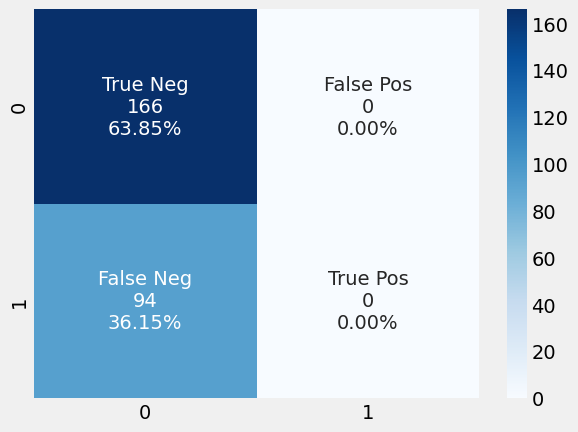

In [32]:
clas_result_series = classification_results(y_inversed_test_l_cat, y_inversed_pred_cat, strategy)
df_clas_results = pd.DataFrame()
df_clas_results = pd.concat([df_clas_results, clas_result_series.to_frame().T], ignore_index=True)
clas_res_output_path = f'{COMPANY}_class_test_results.csv'
df_clas_results.to_csv(clas_res_output_path, mode='a', header=not os.path.exists(clas_res_output_path))
plot_predictions(y_inversed_test_l_cat, y_inversed_pred_cat)

In [33]:
for i in range(30):
    print(y_inversed_pred[i], y_inversed_pred_cat[i])

0.02782253421530087 0
0.00926321637932849 0
0.0005036569956588452 0
-0.0004140178463443514 0
0.001474750821386997 0
-0.0013218773887229973 0
0.0030546496565535333 0
0.008811705848369766 0
0.007906501734249803 0
-0.0025287712193537842 0
-0.007363081274792224 0
0.013615611756363437 0
0.009809165006262319 0
0.011267973613540962 0
0.002530190766061362 0
-0.006620303667590886 0
-0.0005904334327553745 0
-0.008381793981098333 0
0.014216261530603284 0
0.0035627238461255206 0
0.011870448783826489 0
0.011433025181686082 0
0.001119389062549686 0
-0.006448399272516413 0
0.004801638025136161 0
-0.00592126808319212 0
-0.04905261661678887 0
0.04432660793899885 0
0.01236449340452983 0
0.005022062189410023 0
